# Loss function, optimizer and schedulers

In [8]:
%run __common.py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.10/dist-packages/modulus/distributed/manager.py:329: UserWarning: Distributed manager is already intialized
  warn("Distributed manager is already intialized")




After the `area` computation, thus from [1] the loss and optimization objects are initialized. The Adam optimizer and the scheduler are well known, but the loss is a function named `GraphCastLossFunction`. What is it doing?

```python
class GraphCastTrainer(BaseTrainer):
    def __init__(self, cfg: DictConfig, dist, rank_zero_logger):
        ...
        if cfg.synthetic_dataset:
            ...
        else:
            self.criterion = GraphCastLossFunction(
                self.area,
                self.channels_list,
                cfg.dataset_metadata_path,
                cfg.time_diff_std_path,
            )
```

The definition is found in [2] (here pasted and simplified for reading):

```python
class GraphCastLossFunction(nn.Module):
    """Loss function as specified in GraphCast."""

    def __init__(self, area, channels_list, dataset_metadata_path, time_diff_std_path): 
        self.area = area
        self.channel_dict = self.get_channel_dict(dataset_metadata_path, channels_list)
        self.variable_weights = self.assign_variable_weights()
        self.time_diff_std = self.get_time_diff_std(time_diff_std_path, channels_list)

    def forward(self, invar, outvar):
        """Implicit forward function which computes the loss given a prediction and the corresponding targets."""
        # outvar normalization
        loss = (invar - outvar) ** 2  # [T,C,H,W]
        # weighted by inverse variance
        loss = (loss * 1.0 / torch.square(self.time_diff_std.view(1, -1, 1, 1).to(loss.device)))
        # weighted by variables
        variable_weights = self.variable_weights.view(1, -1, 1, 1).to(loss.device)
        loss = loss * variable_weights  # [T,C,H,W]
        # weighted by area
        loss = loss.mean(dim=(0, 1))
        loss = torch.mul(loss, self.area)
        loss = loss.mean()
        return loss

    def get_time_diff_std(self, time_diff_std_path, channels_list):
        """Gets the time difference standard deviation"""
        if time_diff_std_path is not None:
            time_diff_np = np.load(time_diff_std_path)
            time_diff_np = time_diff_np[:, channels_list, ...]
            return torch.FloatTensor(time_diff_np)
        else:
            return torch.tensor([1.0], dtype=torch.float)

    def get_channel_dict(self, dataset_metadata_path, channels_list):
        """Gets lists of surface and atmospheric channels"""
        with open(dataset_metadata_path, "r") as f:
            data_json = json.load(f)
            channel_list = [data_json["coords"]["channel"][c] for c in channels_list]

            # separate atmosphere and surface variables
            channel_dict = {"surface": [], "atmosphere": []}
            for each_channel in channel_list:
                if each_channel[-1].isdigit():
                    channel_dict["atmosphere"].append(each_channel)
                else:
                    channel_dict["surface"].append(each_channel)
            return channel_dict

    def parse_variable(self, variable_list):
        """Parse variable into its letter and numeric parts."""
        for i, char in enumerate(variable_list):
            if char.isdigit():
                return variable_list[:i], int(variable_list[i:])

    def calculate_linear_weights(self, variables):
        """Calculate weights for each variable group."""
        groups = defaultdict(list)
        # Group variables by their first letter
        for variable in variables:
            letter, number = self.parse_variable(variable)
            groups[letter].append((variable, number))
        # Calculate weights for each group
        weights = {}
        for values in groups.values():
            total = sum(number for _, number in values)
            for variable, number in values:
                weights[variable] = number / total

        return weights

    def assign_surface_weights(self):
        """Assigns weights to surface variables"""
        surface_weights = {i: 0.1 for i in self.channel_dict["surface"]}
        if "t2m" in surface_weights:
            surface_weights["t2m"] = 1
        return surface_weights

    def assign_atmosphere_weights(self):
        """Assigns weights to atmospheric variables"""
        return self.calculate_linear_weights(self.channel_dict["atmosphere"])

    def assign_variable_weights(self):
        """assigns per-variable per-pressure level weights"""
        surface_weights_dict = self.assign_surface_weights()
        atmosphere_weights_dict = self.assign_atmosphere_weights()
        surface_weights = list(surface_weights_dict.values())
        atmosphere_weights = list(atmosphere_weights_dict.values())
        variable_weights = torch.cat(
            (torch.FloatTensor(surface_weights), torch.FloatTensor(atmosphere_weights))
        )  # [num_channel]
        return variable_weights
```

Can I even initialize it? Let's execute one by one all the steps in `__init__()`.

- [1] https://vscode.dev/github.com/NVIDIA/modulus/blob/main/examples/weather/graphcast/train_graphcast.py#L225
- [2] https://vscode.dev/github.com/NVIDIA/modulus/blob/main/modulus/utils/graphcast/loss.py#L118

In [9]:
area, channels_list, cfg.dataset_metadata_path, cfg.time_diff_std_path

(tensor([[6.8757e-08, 6.8757e-08, 6.8757e-08,  ..., 6.8757e-08, 6.8757e-08,
          6.8757e-08],
         [6.8633e-03, 6.8633e-03, 6.8633e-03,  ..., 6.8633e-03, 6.8633e-03,
          6.8633e-03],
         [1.3727e-02, 1.3727e-02, 1.3727e-02,  ..., 1.3727e-02, 1.3727e-02,
          1.3727e-02],
         ...,
         [1.3727e-02, 1.3727e-02, 1.3727e-02,  ..., 1.3727e-02, 1.3727e-02,
          1.3727e-02],
         [6.8633e-03, 6.8633e-03, 6.8633e-03,  ..., 6.8633e-03, 6.8633e-03,
          6.8633e-03],
         [6.8757e-08, 6.8757e-08, 6.8757e-08,  ..., 6.8757e-08, 6.8757e-08,
          6.8757e-08]]),
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 '/mnt/data-slow/data/FCN_ERA5_data_v0/metadata.json',
 '/mnt/data-slow/data/FCN_ERA5_data_v0/stats/time_diff_std.npy')

The `/data/era5_75var/metadata/data.json` file is nowhere to be found. I also do not have a 75vars dataset, but a 21 given the ERA5 dataset downloaded from NERSC via Globus. I try by creating one that fits the purpose of the code above, although it might be incomplete.

Copying the `get_channel_dict()` function from [1], to run it here against a `metadata.json` file I created studying the data downloaded from the NERSC data repo and freshly downloaded data from CDS (#TODO: add ref. to the `CDS_ERA5_2014_names_reverse_engineering` work).

```python
class GraphCastLossFunction(nn.Module):
    ...
    def get_channel_dict(self, dataset_metadata_path, channels_list):
        """Gets lists of surface and atmospheric channels"""
        with open(dataset_metadata_path, "r") as f:
            data_json = json.load(f)
            channel_list = [data_json["coords"]["channel"][c] for c in channels_list]

            # separate atmosphere and surface variables
            channel_dict = {"surface": [], "atmosphere": []}
            for each_channel in channel_list:
                if each_channel[-1].isdigit():
                    channel_dict["atmosphere"].append(each_channel)
                else:
                    channel_dict["surface"].append(each_channel)
            return channel_dict
```

- [1] https://vscode.dev/github.com/NVIDIA/modulus/blob/main/modulus/utils/graphcast/loss.py#L171

In [10]:
cfg.dataset_metadata_path = "/mnt/data-slow/data/FCN_ERA5_data_v0/metadata.json"

def get_channel_dict(dataset_metadata_path, channels_list):
    """Gets lists of surface and atmospheric channels"""
    with open(dataset_metadata_path, "r") as f:
        data_json = json.load(f)
        channel_list = [data_json["coords"]["channel"][c] for c in channels_list]
        
        # separate atmosphere and surface variables
        channel_dict = {"surface": [], "atmosphere": []}
        for each_channel in channel_list:
            if each_channel[-1].isdigit():
                channel_dict["atmosphere"].append(each_channel)
            else:
                channel_dict["surface"].append(each_channel)
        return channel_dict

channel_dict = get_channel_dict(cfg.dataset_metadata_path, channels_list)
channel_dict

{'surface': ['10u', '10v', 't2m', 'sp', 'msl', 'tcwv', 'sst'],
 'atmosphere': ['t_850',
  'u_1000',
  'v_1000',
  'z_1000',
  'u_850',
  'v_850',
  'z_850',
  'u_500',
  'v_500',
  'z_500',
  't_500',
  'z_50',
  'r_500',
  'r_850']}

The third step is `assign_variable_weights()`:


In [11]:
from collections import defaultdict

def assign_variable_weights(channel_dict):
    """assigns per-variable per-pressure level weights"""
    surface_weights_dict = assign_surface_weights(channel_dict)
    print(f"{surface_weights_dict=}")
    atmosphere_weights_dict = assign_atmosphere_weights(channel_dict)
    print(f"{atmosphere_weights_dict=}")
    
    surface_weights = list(surface_weights_dict.values())
    print("\tsurface_weights_dict.dict()=", surface_weights_dict.values())
    atmosphere_weights = list(atmosphere_weights_dict.values())
    print("\tatmosphere_weights.dict()=", atmosphere_weights_dict.values())
    variable_weights = torch.cat(
        (torch.FloatTensor(surface_weights), torch.FloatTensor(atmosphere_weights))
    )  # [num_channel]
    return variable_weights

# Required
def assign_surface_weights(channel_dict):
    """Assigns weights to surface variables"""
    surface_weights = {i: 0.1 for i in channel_dict["surface"]}
    if "t2m" in surface_weights:
        surface_weights["t2m"] = 1
    return surface_weights

# Required
def assign_atmosphere_weights(channel_dict):
    """Assigns weights to atmospheric variables"""
    return calculate_linear_weights(channel_dict["atmosphere"])

# Required
def calculate_linear_weights(variables):
    """Calculate weights for each variable group."""
    groups = defaultdict(list)
    # Group variables by their first letter
    for variable in variables:
        letter, number = parse_variable(variable)
        print("\tSplit result:", variable, letter, number)
        groups[letter].append((variable, number))
    print(f"\t{groups=}")
    # Calculate weights for each group
    weights = {}
    for key, values in groups.items():
        print("\tTotal:", key, sum(number for _, number in values))
        total = sum(number for _, number in values)
        for variable, number in values:
            weights[variable] = number / total

    return weights

# Required
def parse_variable(variable_list):
    """Parse variable into its letter and numeric parts."""
    for i, char in enumerate(variable_list):
        if char.isdigit():
            return variable_list[:i], int(variable_list[i:])

variable_weights = assign_variable_weights(channel_dict)
variable_weights

surface_weights_dict={'10u': 0.1, '10v': 0.1, 't2m': 1, 'sp': 0.1, 'msl': 0.1, 'tcwv': 0.1, 'sst': 0.1}
	Split result: t_850 t_ 850
	Split result: u_1000 u_ 1000
	Split result: v_1000 v_ 1000
	Split result: z_1000 z_ 1000
	Split result: u_850 u_ 850
	Split result: v_850 v_ 850
	Split result: z_850 z_ 850
	Split result: u_500 u_ 500
	Split result: v_500 v_ 500
	Split result: z_500 z_ 500
	Split result: t_500 t_ 500
	Split result: z_50 z_ 50
	Split result: r_500 r_ 500
	Split result: r_850 r_ 850
	groups=defaultdict(<class 'list'>, {'t_': [('t_850', 850), ('t_500', 500)], 'u_': [('u_1000', 1000), ('u_850', 850), ('u_500', 500)], 'v_': [('v_1000', 1000), ('v_850', 850), ('v_500', 500)], 'z_': [('z_1000', 1000), ('z_850', 850), ('z_500', 500), ('z_50', 50)], 'r_': [('r_500', 500), ('r_850', 850)]})
	Total: t_ 1350
	Total: u_ 2350
	Total: v_ 2350
	Total: z_ 2400
	Total: r_ 1350
atmosphere_weights_dict={'t_850': 0.6296296296296297, 't_500': 0.37037037037037035, 'u_1000': 0.425531914893617, '

tensor([0.1000, 0.1000, 1.0000, 0.1000, 0.1000, 0.1000, 0.1000, 0.6296, 0.3704,
        0.4255, 0.3617, 0.2128, 0.4255, 0.3617, 0.2128, 0.4167, 0.3542, 0.2083,
        0.0208, 0.3704, 0.6296])

So, `self.assign_variable_weights()` is producing a list of weights seemingly representing the importance of each variable.
Given that I built the `metadata.json` file from scratch, I need to be careful because the atmospheric variable names carry the pressure level used on the weight mechanism. I do not know what sorting they had in the original metadata file. At the moment it seems that channels higher in the atmosphere (i.e. lower pressure level value) have lower weights.


The invokation of `GraphCastLossFunction` requires also `cfg.time_diff_std_path` which again is a file I do not have. But, the script `/mnt/data-slow/dsm/modulus/examples/weather/graphcast/compute_time_diff_std.py` seems to be made for computing that. I run it on my development dataset, but it will need to be recomputed on the full dataset. #TODO

```sh
schups@workbench-standard:/mnt/data-slow/dsm/modulus/examples/weather/graphcast$ docker exec -it modulus bash

root@76ecc0b7d6b6:/mnt/data-slow/dsm/modulus/examples/weather/graphcast# cd /mnt/data-slow/dsm/modulus/examples/weather/graphcast
root@76ecc0b7d6b6:/mnt/data-slow/dsm/modulus/examples/weather/graphcast# python compute_time_diff_std.py dataset_path="/mnt/data-slow/data/FCN_ERA5_data_v0" num_channels_climate=21
root@76ecc0b7d6b6:/mnt/data-slow/dsm/modulus/examples/weather/graphcast# export MODULUS_DISTRIBUTED_INITIALIZATION_METHOD=ENV
root@76ecc0b7d6b6:/mnt/data-slow/dsm/modulus/examples/weather/graphcast# export MASTER_PORT=12356
root@76ecc0b7d6b6:/mnt/data-slow/dsm/modulus/examples/weather/graphcast# export MASTER_ADDR=localhost
root@76ecc0b7d6b6:/mnt/data-slow/dsm/modulus/examples/weather/graphcast# export WORLD_SIZE=1
root@76ecc0b7d6b6:/mnt/data-slow/dsm/modulus/examples/weather/graphcast# export RANK=0
root@76ecc0b7d6b6:/mnt/data-slow/dsm/modulus/examples/weather/graphcast# python compute_time_diff_std.py
...
Loaded training datapipe of length 2816
...
Number of iterations 2600
Number of iterations 2700
Number of iterations 2800
ended!
root@76ecc0b7d6b6:/mnt/data-slow/dsm/modulus/examples/weather/graphcast# ll outputs/graphcast/
total 20
drwxr-xr-x 3 root root 4096 Nov 24 16:47 ./
drwxr-xr-x 3 root root 4096 Nov 24 15:47 ../
drwxr-xr-x 2 root root 4096 Nov 24 15:47 .hydra/
-rw-r--r-- 1 root root    0 Nov 24 15:47 graphcast.log
-rw-r--r-- 1 root root  212 Nov 24 16:47 time_diff_mean_new.npy
-rw-r--r-- 1 root root  212 Nov 24 16:47 time_diff_std_new.npy
schups@workbench-standard:/mnt/data-slow/dsm/modulus/examples/weather/graphcast$ cp outputs/graphcast/time_diff_mean_new.npy /mnt/data-slow/data/FCN_ERA5_data_v0/stats/time_diff_mean.npy
schups@workbench-standard:/mnt/data-slow/dsm/modulus/examples/weather/graphcast$ cp outputs/graphcast/time_diff_std_new.npy /mnt/data-slow/data/FCN_ERA5_data_v0/stats/time_diff_std.npy
```

In [12]:
cfg.time_diff_std_path = "/mnt/data-slow/data/FCN_ERA5_data_v0/stats/time_diff_std.npy"

time_diff_std = np.load(cfg.time_diff_std_path)
time_diff_std.shape, time_diff_std

((1, 21),
 array([[4.16300774e-01, 5.57157755e-01, 1.49079591e-01, 2.71600243e-02,
         2.00262755e-01, 1.08901009e-01, 4.15297985e-01, 5.57294905e-01,
         2.00277835e-01, 3.87176871e-01, 5.74951947e-01, 1.29234523e-01,
         3.37315410e-01, 5.33735752e-01, 7.05657974e-02, 1.18547514e-01,
         3.54452096e-02, 6.91740930e-01, 7.02248693e-01, 2.17077613e-01,
         2.63473453e-06]], dtype=float32))

I can now look into the last step of the `__init__()` function.

In [13]:
def get_time_diff_std(time_diff_std_path, channels_list):
    """Gets the time difference standard deviation"""
    if time_diff_std_path is not None:
        time_diff_np = np.load(time_diff_std_path)
        time_diff_np = time_diff_np[:, channels_list, ...]
        return torch.FloatTensor(time_diff_np)
    else:
        return torch.tensor([1.0], dtype=torch.float)

time_diff_std = get_time_diff_std(cfg.time_diff_std_path, channels_list)
time_diff_std.shape, time_diff_std

(torch.Size([1, 21]),
 tensor([[4.1630e-01, 5.5716e-01, 1.4908e-01, 2.7160e-02, 2.0026e-01, 1.0890e-01,
          4.1530e-01, 5.5729e-01, 2.0028e-01, 3.8718e-01, 5.7495e-01, 1.2923e-01,
          3.3732e-01, 5.3374e-01, 7.0566e-02, 1.1855e-01, 3.5445e-02, 6.9174e-01,
          7.0225e-01, 2.1708e-01, 2.6347e-06]]))

I can try initializing the object now.

In [14]:
from modulus.utils.graphcast.loss import GraphCastLossFunction

criterion = GraphCastLossFunction(area, channels_list, cfg.dataset_metadata_path, cfg.time_diff_std_path)
criterion.variable_weights

tensor([0.1000, 0.1000, 1.0000, 0.1000, 0.1000, 0.1000, 0.1000, 0.6296, 0.3704,
        0.4255, 0.3617, 0.2128, 0.4255, 0.3617, 0.2128, 0.4167, 0.3542, 0.2083,
        0.0208, 0.3704, 0.6296])

Good. Now to the loss function itself:

```python
class GraphCastLossFunction(nn.Module):
    ...
    def forward(self, invar, outvar):
        """ Implicit forward function which computes the loss given a prediction and the corresponding targets."""
        # outvar normalization
        loss = (invar - outvar) ** 2  # [T,C,H,W]
        # weighted by inverse variance
        loss = (loss * 1.0 / torch.square(self.time_diff_std.view(1, -1, 1, 1).to(loss.device)))
        # weighted by variables
        variable_weights = self.variable_weights.view(1, -1, 1, 1).to(loss.device)
        loss = loss * variable_weights  # [T,C,H,W]
        # weighted by area
        loss = loss.mean(dim=(0, 1))
        loss = torch.mul(loss, self.area)
        loss = loss.mean()
        return loss
```

The squared error is weighted by the inverse of the variance, giving more importance (in the loss value) to those channels believed to be more predictable (i.e. those with less variance).

In [15]:
1 / torch.square(time_diff_std.view(1, -1, 1, 1))

tensor([[[[5.7701e+00]],

         [[3.2214e+00]],

         [[4.4995e+01]],

         [[1.3556e+03]],

         [[2.4934e+01]],

         [[8.4321e+01]],

         [[5.7980e+00]],

         [[3.2198e+00]],

         [[2.4931e+01]],

         [[6.6708e+00]],

         [[3.0251e+00]],

         [[5.9875e+01]],

         [[8.7888e+00]],

         [[3.5103e+00]],

         [[2.0082e+02]],

         [[7.1157e+01]],

         [[7.9595e+02]],

         [[2.0898e+00]],

         [[2.0278e+00]],

         [[2.1221e+01]],

         [[1.4405e+11]]]])

The weight for the last channel seems problematic. 

Given such an enourmous value it is going to dominate the others. Recalling from the work done on the dataset analysis (wrt. curated ERA5 hosted at NERSC), we know that this field (representing `sst`) has the nan values filled with a fixed value. The channel is therefore not really predictable as its _std_ suggests. Its _std_ is low because of this value filling. The `time_diff_std.npy` and `time_diff_mean.npy` files should account for this. 

I choose to continue investigating the code. Once I am able to visualize a loss curve I will come back to this. #TODO

Now I mock a prediction and a ground truth to test the code. I make it so that they are adjacent thus similar. The format needed is [T,C,H,W].

In [16]:
with h5py.File('/mnt/data-slow/data/FCN_ERA5_data_v0/test/2017.h5', 'r') as h5_file:
    invar = torch.tensor(h5_file["fields"][[0], ...], device="cpu")
    outvar = torch.tensor(h5_file["fields"][[1], ...], device="cpu")

invar.shape, outvar.shape

print(f"Channel     {'Min':>20} {'Max':>20} {'Mean':>20} {'Std':>20}")
for c in range(invar.shape[1]):
    print(f"Channel {c:2}: {invar[:, c].min():20.3f} {invar[:, c].max():20.3f} {invar[:, c].mean():20.3f} {invar[:, c].std():20.3f}")

Channel                      Min                  Max                 Mean                  Std
Channel  0:              -24.114               19.295               -0.633                5.265
Channel  1:              -18.044               23.308               -0.197                4.647
Channel  2:              217.136              315.140              277.632               19.121
Channel  3:            48678.078           104551.297            96800.555             9393.631
Channel  4:            95715.930           104808.453           101064.695             1278.189
Channel  5:              233.262              309.219              273.930               14.422
Channel  6:              -24.582               19.950               -0.824                5.891
Channel  7:              -24.187               26.163               -0.237                5.255
Channel  8:            -3453.409             3564.874              834.768              999.277
Channel  9:              -34.715        

In [17]:
loss1 = (invar - outvar) ** 2  # [T,C,H,W]
print(loss1.shape)

print(f"Channel     {'Min':>20} {'Max':>20} {'Mean':>20} {'Std':>20}")
for c in range(loss1.shape[1]):
    print(f"Channel {c:2}: {loss1[:, c].min():20.3f} {loss1[:, c].max():20.3f} {loss1[:, c].mean():20.3f} {loss1[:, c].std():20.3f}")

torch.Size([1, 21, 721, 1440])
Channel                      Min                  Max                 Mean                  Std
Channel  0:                0.000              541.401                4.931               17.389
Channel  1:                0.000              920.531                6.389               29.419
Channel  2:                0.000              520.254                5.624               18.685
Channel  3:                0.000          3115666.250            64076.488           163812.719
Channel  4:                0.000          3113101.750            72594.531           177758.969
Channel  5:                0.000              207.590                2.430                6.672
Channel  6:                0.000              880.958                6.008               21.239
Channel  7:                0.000             1597.546                8.085               41.118
Channel  8:                0.000          2146163.000            44334.875           107603.836
Channel  

In [19]:
# weighted by inverse variance
weights = 1.0 / torch.square(time_diff_std.view(1, -1, 1, 1))
print(loss1.shape, weights.shape)
loss2 = loss1 * weights
print(loss2.shape)

#print(f"Channel     {'Min':>20} {'Max':>20} {'Mean':>20} {'Std':>20} {'Weight':>20}")
print(f"Channel     {'Weight':>20}")
for c in range(loss2.shape[1]):
    #print(f"Channel {c:2}: {loss2[:, c].min():20.3f} {loss2[:, c].max():20.3f} {loss2[:, c].mean():20.3f} {loss2[:, c].std():20.3f} {weights[0, c, 0, 0]:20.3f}")
    print(f"Channel {c:2}: {weights[0, c, 0, 0]:20.3f}")

torch.Size([1, 21, 721, 1440]) torch.Size([1, 21, 1, 1])
torch.Size([1, 21, 721, 1440])
Channel                   Weight
Channel  0:                5.770
Channel  1:                3.221
Channel  2:               44.995
Channel  3:             1355.625
Channel  4:               24.934
Channel  5:               84.321
Channel  6:                5.798
Channel  7:                3.220
Channel  8:               24.931
Channel  9:                6.671
Channel 10:                3.025
Channel 11:               59.875
Channel 12:                8.789
Channel 13:                3.510
Channel 14:              200.822
Channel 15:               71.157
Channel 16:              795.948
Channel 17:                2.090
Channel 18:                2.028
Channel 19:               21.221
Channel 20:     144054321152.000


In [18]:
# weighted by variables
weights = variable_weights.view(1, -1, 1, 1)
loss3 = loss2 * weights  # [T,C,H,W]
print(loss2.shape, weights.shape)

print(f"Channel     {'Min':>20} {'Max':>20} {'Mean':>20} {'Std':>20} {'Weight':>20}")
for c in range(loss3.shape[1]):
    print(f"Channel {c:2}: {loss3[:, c].min():20.3f} {loss3[:, c].max():20.3f} {loss3[:, c].mean():20.3f} {loss3[:, c].std():20.3f} {weights[0, c, 0, 0]:20.3f}")

torch.Size([1, 21, 721, 1440]) torch.Size([1, 21, 1, 1])
Channel                      Min                  Max                 Mean                  Std               Weight
Channel  0:                0.000              312.396                2.845               10.033                0.100
Channel  1:                0.000              296.539                2.058                9.477                0.100
Channel  2:                0.000            23408.805              253.048              840.747                1.000
Channel  3:                0.000        422367616.000          8686371.000         22206868.000                0.100
Channel  4:                0.000          7762345.000           181010.406           443232.062                0.100
Channel  5:                0.000             1750.419               20.486               56.257                0.100
Channel  6:                0.000              510.782                3.484               12.314                0.100
Channel

In [20]:
loss4 = loss3.mean(dim=(0, 1))
loss4.shape, loss4

(torch.Size([721, 1440]),
 tensor([[335494.8750, 335494.8750, 335494.8750,  ..., 335494.8750,
          335494.8750, 335494.8750],
         [347094.2812, 347142.3750, 347142.3750,  ..., 347057.7500,
          347205.0625, 347094.4688],
         [347924.0938, 348033.6250, 347827.6562,  ..., 346031.5312,
          348020.0938, 347883.1875],
         ...,
         [ 36726.3945,  37983.4531,  37985.5938,  ...,  37207.4453,
           37014.7734,  37019.6953],
         [ 40029.8164,  39731.4453,  40236.8164,  ...,  40304.7773,
           40080.3750,  40074.5547],
         [ 43227.1562,  43227.1562,  43227.1562,  ...,  43227.1562,
           43227.1562,  43227.1562]]))

I suspect there are outliers.

In [21]:
loss5 = torch.mul(loss4, area)
loss5.shape

torch.Size([721, 1440])

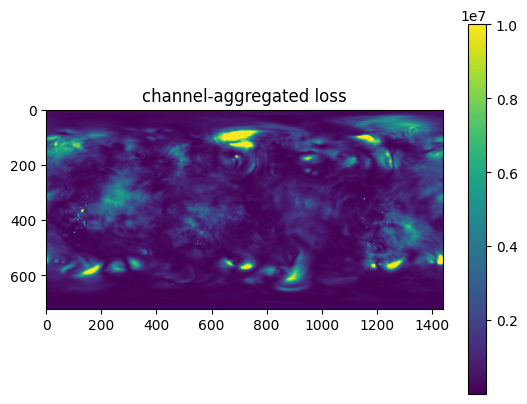

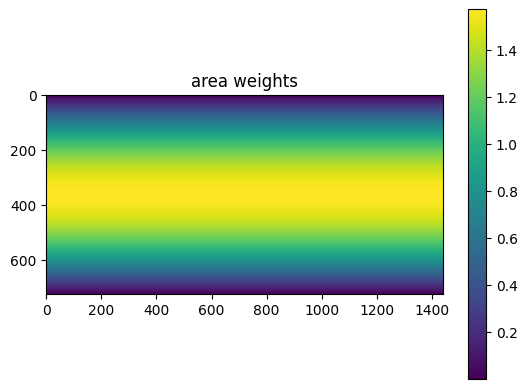

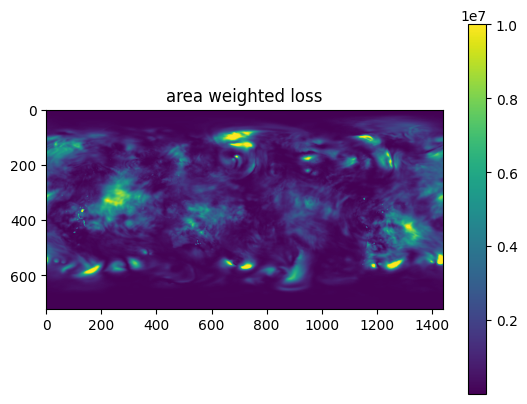

In [23]:
# For curiosity, let's visualise the loss
plt.imshow(torch.clamp(loss4, max=1e7)) # <--- Needed to clamp to see something at all
plt.colorbar()
plt.title("channel-aggregated loss")
plt.show()

plt.imshow(area)
plt.colorbar()
plt.title("area weights")
plt.show()

plt.imshow(torch.clamp(loss5, max=1e7))
plt.colorbar()
plt.title("area weighted loss")
plt.show()

In [24]:
loss5.mean()

tensor(1219143.6250)

## Testing loss with the actual data

In [2]:
from modulus.datapipes.climate import ERA5HDF5Datapipe

channels_list = [i for i in range(cfg.num_channels_climate)]
dtype = torch.bfloat16 if cfg.full_bf16 else torch.float32

input_res = (721, 1440)

latitudes = torch.linspace(-90, 90, steps=input_res[0])
longitudes = torch.linspace(-180, 180, steps=input_res[1] + 1)[1:]
lat_lon_grid = torch.stack(torch.meshgrid(latitudes, longitudes, indexing="ij"), dim=-1)

datapipe = ERA5HDF5Datapipe(
    data_dir=to_absolute_path(os.path.join(cfg.dataset_path, "train")),
    stats_dir=to_absolute_path(os.path.join(cfg.dataset_path, "stats")),
    channels=channels_list,
    latlon_resolution=cfg.latlon_res,
    interpolation_type=None,
    num_samples_per_year=cfg.num_samples_per_year_train,
    num_steps=1,
    num_history=cfg.num_history,
    use_cos_zenith=cfg.use_cos_zenith,
    use_time_of_year_index=cfg.use_time_of_year_index,
    cos_zenith_args={
        "dt": cfg.dt,
        "start_year": cfg.start_year,
    },
    batch_size=1,
    num_workers=cfg.num_workers,
    device=dist.device,
    process_rank=dist.rank,
    world_size=dist.world_size,
)

area = normalized_grid_cell_area(lat_lon_grid[:, :, 0], unit="deg")
area = area.to(dtype=dtype).to(device=dist.device)


[13:36:09 - INFO] ERA5 file found: /mnt/data-slow/data/FCN_ERA5_data_v0/train/2014.h5
[13:36:09 - INFO] ERA5 file found: /mnt/data-slow/data/FCN_ERA5_data_v0/train/2015.h5
[13:36:09 - INFO] Number of years: 2
[13:36:09 - INFO] Getting file stats from /mnt/data-slow/data/FCN_ERA5_data_v0/train/2014.h5
[13:36:09 - INFO] data_samples_per_year: 1459 = (1460 - (1 + 0) * 1) // 1) * 1
[13:36:09 - INFO] Input image shape: (721, 1440)
[13:36:09 - INFO] Number of samples/year: 1408
[13:36:09 - INFO] Number of channels available: 21


In [3]:
data = next(iter(datapipe))

invar = data[0]["invar"]
outvar = data[0]["outvar"]
cos_zenith = data[0]["cos_zenith"]
time_idx = data[0]["time_of_year_idx"].item()

invar.shape, outvar.shape, cos_zenith.shape, time_idx

(torch.Size([1, 21, 721, 1440]),
 torch.Size([1, 1, 21, 721, 1440]),
 torch.Size([1, 2, 1, 721, 1440]),
 878)

In [4]:
from train_utils import count_trainable_params, prepare_input
from modulus.utils.graphcast.data_utils import StaticData

static_data = StaticData(
    cfg.static_dataset_path,
    latitudes,
    longitudes
).get()

static_data = static_data.to(device=dist.device)

assert cfg.num_channels_static == static_data.size(1), f"Number of static channels in model ({cfg.num_channels_static}) does not match the static data ({static_data.size(1)})"

invar_cat = prepare_input(
    invar,
    cos_zenith,
    num_history=cfg.num_history,
    static_data=static_data,
    step=1,
    time_idx=time_idx,
    stride=cfg.stride,
    dt=cfg.dt,
    num_samples_per_year=cfg.num_samples_per_year_train,
    device=dist.device,
)
invar_cat, outvar = invar_cat.to(dtype=dtype), outvar.to(dtype=dtype)

invar_cat.shape, outvar.shape

/usr/local/lib/python3.10/dist-packages/modulus/utils/graphcast/data_utils.py:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  ds = torch.tensor(nc.Dataset(self.lsm_path)["lsm"], dtype=torch.float32)


(torch.Size([1, 31, 721, 1440]), torch.Size([1, 1, 21, 721, 1440]))

In [ ]:
np.save('/mnt/data-slow/dsm/review/tmp_input.npy', invar_cat.to(torch.float32).cpu().numpy())

Process SpawnProcess-6:
Process SpawnProcess-3:
Process SpawnProcess-4:
Process SpawnProcess-1:
Process SpawnProcess-2:
Process SpawnProcess-8:
Process SpawnProcess-5:
Process SpawnProcess-7:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 462, in worker
    scheduled, shm_chunk = worker_context.get_task()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 462, in worker
    scheduled, shm_chunk = worker_context.get_t

In [16]:
from modulus.utils.graphcast.loss import GraphCastLossFunction

criterion = GraphCastLossFunction(
    area,
    channels_list,
    cfg.dataset_metadata_path,
    cfg.time_diff_std_path,
)

loss = criterion(invar_cat, outvar)
loss

[autoreload of modulus.utils.graphcast.loss failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extension

cippa torch.Size([1, 31, 721, 1440]) torch.Size([1, 1, 21, 721, 1440])


RuntimeError: The size of tensor a (31) must match the size of tensor b (21) at non-singleton dimension 2